epoch : 0, loss : 4052.859375
epoch : 10, loss : 1876.118896484375
epoch : 20, loss : 1156.7811279296875
epoch : 30, loss : 994.954833984375
epoch : 40, loss : 895.950927734375
epoch : 50, loss : 842.2167358398438
epoch : 60, loss : 805.775390625
epoch : 70, loss : 775.2096557617188
epoch : 80, loss : 736.6156005859375
epoch : 90, loss : 707.1341552734375
epoch : 100, loss : 681.343017578125
epoch : 110, loss : 670.7764282226562
epoch : 120, loss : 653.2122802734375
epoch : 130, loss : 641.7459106445312
epoch : 140, loss : 638.9072265625
epoch : 150, loss : 619.8565673828125
epoch : 160, loss : 610.4940185546875
epoch : 170, loss : 594.3909912109375
epoch : 180, loss : 583.9678955078125
epoch : 190, loss : 571.4385375976562
epoch : 200, loss : 563.3131713867188
epoch : 210, loss : 557.3079833984375
epoch : 220, loss : 545.362060546875
epoch : 230, loss : 547.19287109375
epoch : 240, loss : 543.3491821289062
epoch : 250, loss : 533.930419921875
epoch : 260, loss : 532.3739624023438
epoc

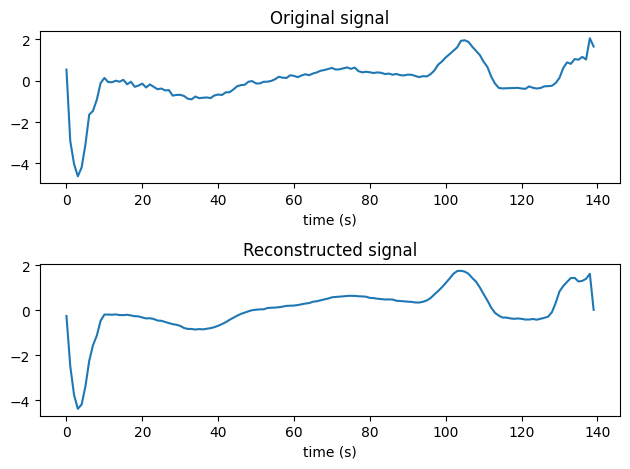

In [8]:
import torch
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import random
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np
from scipy.io import arff, loadmat
from sklearn.model_selection import train_test_split
from utils.util import seed_everything_th, weight_init_xavier_uniform
from models.model import VMD_VAE_DNN
import subprocess

EPOCH = 300
seed = 123456
seed_everything_th(seed)

subprocess.run("julia ./utils/preprocessing.jl")

input_tr = arff.loadarff("./dataset/ECG5000_TRAIN.arff")
input_tr = pd.DataFrame(input_tr[0], dtype=np.float32).values[:,:140].reshape(500, 140)

input_ts = arff.loadarff("./dataset/ECG5000_TEST.arff")
input_ts = pd.DataFrame(input_ts[0], dtype=np.float32).values[:,:140].reshape(4500, 140)

target_tr = loadmat("./dataset/processed_train.mat")["data"].reshape(500, 3, 140)
target_ts = loadmat("./dataset/processed_test.mat")["data"].reshape(4500, 3, 140)

train_loader = torch.utils.data.DataLoader(dataset = TensorDataset(torch.FloatTensor(input_tr), torch.FloatTensor(target_tr)), batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = TensorDataset(torch.FloatTensor(input_ts), torch.FloatTensor(target_ts)), batch_size = 32, shuffle = True)

model = VMD_VAE_DNN()
model.apply(weight_init_xavier_uniform)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, eps=1e-8, betas=(0.9, 0.999))

def custom_fn(outputs, inputs, mu, log_var):
    BCE = F.mse_loss(outputs, inputs, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD


for i in range(EPOCH):
    avg_cost = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        out, mu, log_var = model(data)

        cost = custom_fn(out, data, mu, log_var)
        cost.backward()
        optimizer.step()
        avg_cost += cost / len(train_loader)
        
    if i % 10 == 0:
        print("epoch : {0}, loss : {1}".format(i, avg_cost.item()))

imf1_s = []
imf2_s = []
imf3_s = []

imf_all = []

model.eval()
with torch.no_grad(): 
    correct = 0
    total = 0

    for i, (datax, targetx) in enumerate(test_loader):
        out, mu, log_var = model(datax)
        break

plt.figure()
plt.subplot(2,1,1)
plt.plot(datax[0])
plt.title('Original signal')
plt.xlabel('time (s)')
plt.subplot(2,1,2)
plt.plot(out[0])
plt.title('Reconstructed signal')
plt.xlabel('time (s)')
plt.tight_layout()
plt.show()